In [2]:
%%time

##bucket path for the directory where merge_three_vcf output is in 
bucket ='gs://fc-2cae157b-a485-483f-8f33-054640ba106f/98c214bc-6197-41ea-9885-0813c7d22138/Ancestry_Inference/3ea7ff94-130e-43e6-9a36-f8fbd6c800f9/call-CombineVariants/'
#Set name for your case cohort 
cohort_name="Jun2021_RCC_discovery_1459_with_25k_control.vcf.gz"

#make a list of control samples and the name of the file
control_temp=hl.import_vcf("gs://fc-secure-86e78e12-0dff-4089-9b7e-1ca8d9ce40cf/fc-secure-d5512a7a-09a6-4e8b-8144-248afdd2326f/fc-secure-1972e3dc-9185-4841-97bf-36b537e359d1/0ec0eb79-79d1-4efc-ab9b-4d741ddafa55/Subset_VCF/dc41bed8-e938-4d63-b7aa-945f75539aa9/call-GATKSelectVariants/broadascfmlschizo1000g_norelated_2020March2.subset.vcf.gz",n_partitions=200,force_bgz=True)
control_sample_list_temp =control_temp.s.collect()
control_sample_list = list(set(control_sample_list_temp)- set(thousand_G_samplelist))
control_name="broadascfmlschizo1000g_norelated_2020March2"

#Import the merged vcf -> put the name of the file with your cases merged with control and 1kg 

merged_mt=hl.import_vcf(bucket+"case_merged_with_1kg_and_control.vcf.gz",n_partitions=200, force_bgz=True)

#Make a list of case samples 
merged_sample_list=merged_mt.s.collect()
Input_sample_list=list(set(merged_sample_list)-set(thousand_G_samplelist)-set(control_sample_list))
temp01= {"sample_original":Input_sample_list, "cohort":cohort_name}
Input_to_merge=pd.DataFrame(temp01,columns=['sample_original', 'cohort'])


2021-08-28 23:40:41 Hail: INFO: Coerced almost-sorted dataset
2021-08-28 23:40:50 Hail: INFO: Coerced almost-sorted dataset
2021-08-28 23:41:09 Hail: INFO: Coerced almost-sorted dataset


CPU times: user 207 ms, sys: 40 ms, total: 247 ms
Wall time: 53.4 s


##  1st Round of PCA and assignment of continental ancestry 

<b>3-1. Variant filtering and LD_Pruning</b>

<b>3.2. PCA and Random Forest for continental ancestry assignment </b> 

In [1]:
%%time
#Running PCA

pca_eigenvalues, pca_scores, _ = hl.hwe_normalized_pca(filtered_mt.GT)

### convert to pandas table:
pca_scores_pd=pca_scores.to_pandas()

## split the scores column:
pca_scores_pd[['PCA1','PCA2',
                'PCA3','PCA4',
                'PCA5','PCA6',
                'PCA7','PCA8',
                'PCA9','PCA10']] = pd.DataFrame(pca_scores_pd.scores.values.tolist(),
                                                  index= pca_scores_pd.index)

## remove the scores column
pca_scores_pd=pca_scores_pd.drop(columns="scores")

## rename the first column:
pca_scores_pd.rename(columns={"s":"sample_original"}, inplace=True)

#Read in the clinical data
temp_clin_table = hl.import_table("gs://fc-e734351b-f1b6-4677-a5c8-efe72c774013/Reference_files/supercohort_combined_with_info.txt")
clinical_info_1KG_pd=hl.Table.to_pandas(temp_clin_table)

### merge the PCA with the clinical data:
pca_scores_pd_clinical=pd.merge(pca_scores_pd, clinical_info_1KG_pd, on='sample_original', how="left")

### Add cohort labels to cases and controls 
pca_scores_pd_clinical.loc[pca_scores_pd_clinical['sample_original'].apply(lambda x : x in control_sample_list), 'Super_Population'] = control_name
pca_scores_pd_clinical.loc[pca_scores_pd_clinical['sample_original'].apply(lambda x : x in Input_sample_list), 'Super_Population'] = cohort_name

print("PCA done")


### creat a datasets for training from 1000 genomes samples:
training_data=pca_scores_pd_clinical[pca_scores_pd_clinical['Super_Population']
                                       .apply(lambda x : x !=cohort_name and x !=control_name)]

#clean the training set:
training_data["Super_Population"][training_data["Super_Population"]=="EUR"]="1"
training_data["Super_Population"][training_data["Super_Population"]=="AFR"]="2"
training_data["Super_Population"][training_data["Super_Population"]=="EAS"]="3"
training_data["Super_Population"][training_data["Super_Population"]=="SAS"]="4"
training_data["Super_Population"][training_data["Super_Population"]=="AMR"]="5"

### creat a datasets for testing from cases and controls =:
testing_data=pca_scores_pd_clinical[pca_scores_pd_clinical["Super_Population"].
                                      apply(lambda x : x ==cohort_name or x==control_name)]

## define the variables that we want to use to build the model:
predictor_variables_PCA=["PCA1", "PCA2", "PCA3",
                    "PCA4", "PCA5", "PCA6",
                    "PCA7", "PCA8", "PCA9","PCA10"]

x_PCA,y= training_data[predictor_variables_PCA], list(training_data.Super_Population.values)

## ini with parameters:
modelRandom_PCA=RandomForestClassifier()

## cross validation: (5 fold)
modelRandomCV_PCA=cross_val_score(modelRandom_PCA, x_PCA, y, cv=5)

modelRandom_PCA.fit(x_PCA,y)

## predict the unknown ancestry:
ancestry_inference_PCA=modelRandom_PCA.predict(testing_data[predictor_variables_PCA])

## combine back with the testing data:
testing_data["inferred_ancestry_PCA"]=ancestry_inference_PCA


## convert the numbers back into ancestry categories:
testing_data.loc[:,"inferred_ancestry_PCA"]=testing_data.replace("1","EUR")
testing_data.loc[:,"inferred_ancestry_PCA"]=testing_data.replace("2","AFR")
testing_data.loc[:,"inferred_ancestry_PCA"]=testing_data.replace("3","EAS")
testing_data.loc[:,"inferred_ancestry_PCA"]=testing_data.replace("4","SAS")
testing_data.loc[:,"inferred_ancestry_PCA"]=testing_data.replace("5","AMR")

##save all the relevant files so you wont have to run this cell again! 
testing_data.to_csv('testing_data.txt',index=False, sep="\t")
training_data.to_csv('training_data.txt', index= False, sep = '\t')
pca_scores_pd_clinical.to_csv('pca_scores_pd_clinical.txt', index= False, sep = '\t')

!gsutil cp "testing_data.txt" $bucket
!gsutil cp "training_data.txt" $bucket
!gsutil cp "pca_scores_pd_clinical.txt" $bucket



NameError: name 'hl' is not defined

<b> IF YOU WANT TO INCLUDE 1000G IN YOUR FINAL CONTROLS, RUN THIS CELL. IF NOT, DONT :) </b>

In [ ]:
### IF YOU WANT TO INCLUDE 1000G IN YOUR FINAL CONTROLS, RUN THIS CELL. IF NOT, DONT :) 
training_data=pca_scores_pd_clinical[pca_scores_pd_clinical['Super_Population'].apply(lambda x : x !=cohort_name and x !=control_name)]
training_data['inferred_ancestry_PCA'] = training_data['Super_Population']
training_data['Super_Population'] ='1000G'
testing_data = pd.concat([training_data, testing_data])

<b> run from below cell if your notebook runtime was finished before running next steps </b>

In [4]:
### You don't need to run this cell unless you stopped after running cells above 
bucket_txt=bucket+"*.txt"
!gsutil cp $bucket_txt . 

testing_data=pd.read_table("./testing_data.txt",sep="\t")
training_data=pd.read_table("./training_data.txt",sep="\t")
pca_scores_pd_clinical=pd.read_table("./pca_scores_pd_clinical.txt",sep="\t")

Copying gs://fc-a32996b4-1a46-4467-9f74-20714c5d2f96/854e14cf-b7db-4224-bbf2-4415782456bb/CombineVariants_workflow/dad8d8b3-e22d-48b8-9ea5-0135acd0c54b/call-mergechromvcfs/082421_hail_nomissing_pca.txt...
Copying gs://fc-a32996b4-1a46-4467-9f74-20714c5d2f96/854e14cf-b7db-4224-bbf2-4415782456bb/CombineVariants_workflow/dad8d8b3-e22d-48b8-9ea5-0135acd0c54b/call-mergechromvcfs/082421_hail_original.txt...
Copying gs://fc-a32996b4-1a46-4467-9f74-20714c5d2f96/854e14cf-b7db-4224-bbf2-4415782456bb/CombineVariants_workflow/dad8d8b3-e22d-48b8-9ea5-0135acd0c54b/call-mergechromvcfs/082421_hail_original_01.txt...
Copying gs://fc-a32996b4-1a46-4467-9f74-20714c5d2f96/854e14cf-b7db-4224-bbf2-4415782456bb/CombineVariants_workflow/dad8d8b3-e22d-48b8-9ea5-0135acd0c54b/call-mergechromvcfs/082421_hail_original_02.txt...
/ [4 files][221.0 KiB/221.0 KiB]                                                
==> NOTE: You are performing a sequence of gsutil operations that may
run significantly faster if you instea

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3147: DtypeWarning: Columns (11,12,13,14,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


<b> 3-3. Make Figures from first round of PCA and continental ancestry inference </b> 

In [10]:
## setting up plotnames to save, CHANGE TO YOUR OWN COHORT

def plotname(purpose):
    name = purpose + 'Aug2021_RCC_discovery' + '.png'
    return name

plotname('controls_barplot')

## you will set the purpose variable in each plotting cell, so that you can change the name of the output file! 
## i copied these lines to a couple of plots but not all, so you can add to the ones youd like to save and copy to the bucket

'controls_barplotAug2021_RCC_discovery.png'

In [14]:
#Set order of bars and color scheme for 5 continental ancestry groups 

order=["EUR","AFR","EAS","AMR","SAS"]
palette ={"EUR": "royalblue", "AFR": "chocolate", "EAS": "darkred", "SAS": "darkgreen","AMR":"blueviolet"}

Copying file://controls_barplot_Aug2021_RCC_discovery.png [Content-Type=image/png]...
/ [1 files][263.7 KiB/263.7 KiB]                                                
Operation completed over 1 objects/263.7 KiB.                                    


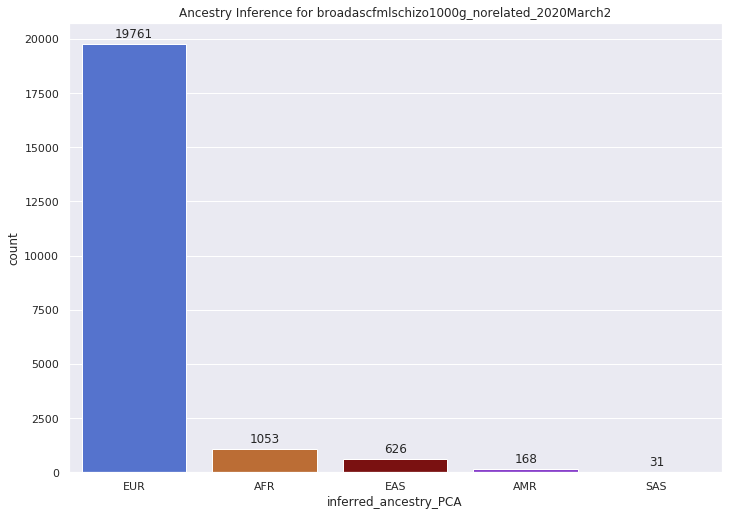

In [15]:
#Ancestry Inference barplot for control

savethis = plotname('controls_barplot_')

seaborn.set(rc={'figure.figsize':(11.7,8.27)}) 
bp=seaborn.countplot(data=testing_data[(testing_data.Super_Population==control_name) | (testing_data.Super_Population=='1000G')]
                     ,order=order,palette=palette,x='inferred_ancestry_PCA')

for p in bp.patches:
    bp.annotate(format(p.get_height(), ''), (p.get_x() + p.get_width() / 2., p.get_height()),
            ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')

plt.title("Ancestry Inference for "+ control_name)

plt.savefig(savethis, bbox_inches='tight', dpi = 500)
!gsutil cp $savethis $bucket

Copying file://cases_barplot_Aug2021_RCC_discovery.png [Content-Type=image/png]...
/ [1 files][233.8 KiB/233.8 KiB]                                                
Operation completed over 1 objects/233.8 KiB.                                    


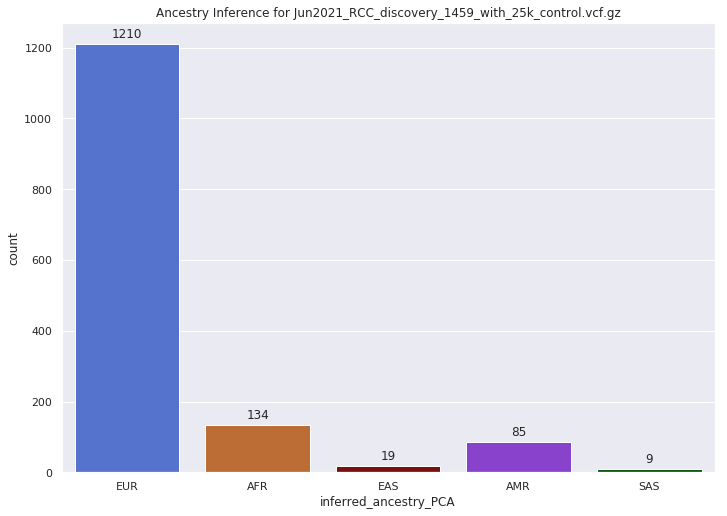

In [17]:
#Ancestry Inference barplot for case
#order2=['EUR', 'AFR', 'SAS','EAS','AMR'] In case you don't have all 5 ancestry groups in cases, change this order list


savethis = plotname('cases_barplot_')
bp2=seaborn.countplot(data=testing_data[testing_data.Super_Population==cohort_name],
                      order=order,palette=palette,x='inferred_ancestry_PCA')

for p in bp2.patches:
    bp2.annotate(format(p.get_height(), ''), (p.get_x() + p.get_width() / 2., p.get_height()),
            ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')

plt.title("Ancestry Inference for "+ cohort_name)

plt.savefig(savethis, bbox_inches='tight', dpi = 500)
!gsutil cp $savethis $bucket

Text(0.5, 0.98, 'Continental ancestry inference PC1 vs PC2')

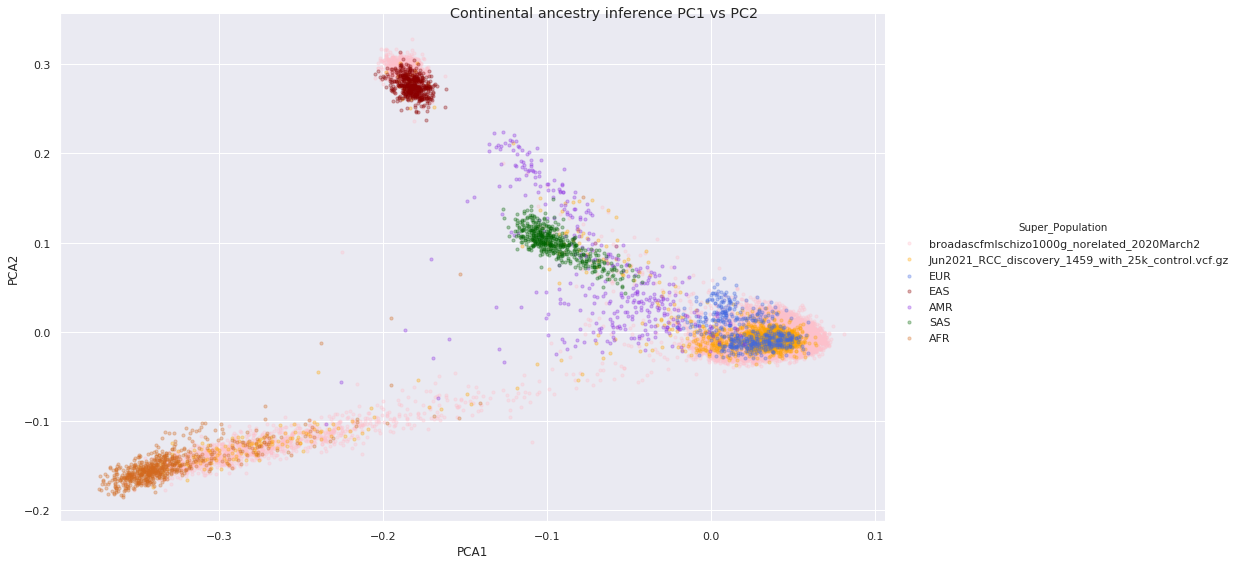

In [22]:
#Figure 1 - Continental Ancestry PC1 vs PC2 

seaborn.set(rc={'figure.figsize':(11.7,8.27)}) 
fg = seaborn.FacetGrid(data=pca_scores_pd_clinical, hue='Super_Population',height=8 , aspect=1.61,
                      palette ={"EUR": "royalblue", "AFR": "chocolate", "EAS": "darkred", "SAS": "darkgreen","AMR":"blueviolet",cohort_name:"orange",control_name:"pink"})
fg.map(plt.scatter, 'PCA1', 'PCA2',alpha=0.3,s=10).add_legend()
fg.fig.suptitle("Continental ancestry inference PC1 vs PC2")

Text(0.5, 0.98, 'Continental ancestry inference PC2 vs PC3')

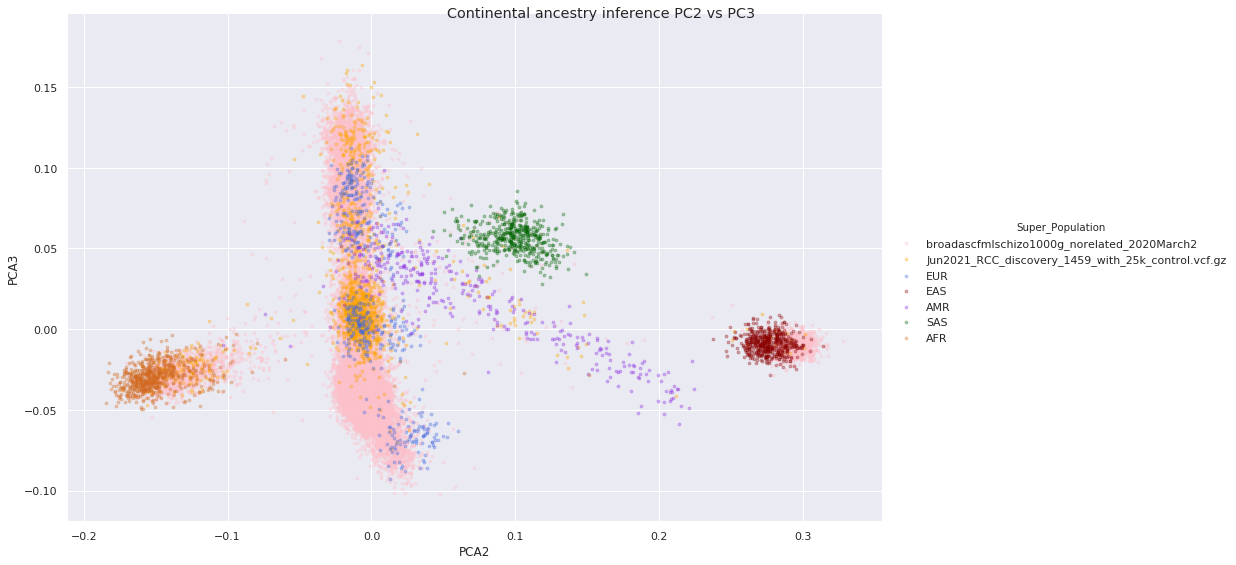

In [23]:
#Figure 2 - Continental Ancestry PC2 vs PC3 

fg = seaborn.FacetGrid(data=pca_scores_pd_clinical, hue='Super_Population', height=8,aspect=1.61,
                      palette ={"EUR": "royalblue", "AFR": "chocolate", "EAS": "darkred", "SAS": "darkgreen","AMR":"blueviolet",cohort_name:"orange",control_name:"pink"})
fg.map(plt.scatter, 'PCA2', 'PCA3',alpha=0.3,s=8).add_legend()
fg.fig.suptitle("Continental ancestry inference PC2 vs PC3")
#fg.set(xlim=(-0.03,0.08))
#fg.set(ylim=(-0.02,0.02))

In [ ]:
#Figure 3 - Continental Ancestry PC1 vs PC3 

fg = seaborn.FacetGrid(data=pca_scores_pd_clinical, hue='Super_Population', height=8,aspect=1.61,
                      palette ={"EUR": "royalblue", "AFR": "chocolate", "EAS": "darkred", "SAS": "darkgreen","AMR":"blueviolet",cohort_name:"orange",control_name:"pink"})
fg.map(plt.scatter, 'PCA1', 'PCA3',alpha=0.3,s=8).add_legend()
fg.fig.suptitle("Continental ancestry inference PC1 vs PC3")
#fg.set(xlim=(-0.03,0.08))
#fg.set(ylim=(-0.07,0.07))

## 2nd Round of PCA and ancestry matching 

<b> 4-1. Divide case/control into smaller matrix tables of each ancestry </b>

In [24]:
%%capture

#In case notebook was stopped in the middle
bucket ='gs://fc-2cae157b-a485-483f-8f33-054640ba106f/98c214bc-6197-41ea-9885-0813c7d22138/Ancestry_Inference/3ea7ff94-130e-43e6-9a36-f8fbd6c800f9/call-CombineVariants/'
merged_mt=hl.import_vcf(bucket+"Jun2021_RCC_discovery_1459_with_25k_control.vcf.gz", n_partitions=200,force_bgz=True)
merged_mt = merged_mt.annotate_entries(GT = hl.if_else(hl.is_defined(merged_mt.GT), merged_mt.GT, hl.Call([0, 0])))


### Divide the matrix table into 5 mts according to the continental ancestry 
First_df=testing_data[["sample_original","inferred_ancestry_PCA"]]
First_df.inferred_ancestry_PCA.unique()
EUR_df=First_df[First_df.inferred_ancestry_PCA == "EUR"]
AFR_df=First_df[First_df.inferred_ancestry_PCA == "AFR"]
AMR_df=First_df[First_df.inferred_ancestry_PCA == "AMR"]
SAS_df=First_df[First_df.inferred_ancestry_PCA == "SAS"]
EAS_df=First_df[First_df.inferred_ancestry_PCA == "EAS"]

EUR_sample = pd.DataFrame({"s": EUR_df.sample_original})
AFR_sample = pd.DataFrame({"s": AFR_df.sample_original})
AMR_sample = pd.DataFrame({"s": AMR_df.sample_original})
SAS_sample = pd.DataFrame({"s": SAS_df.sample_original})
EAS_sample = pd.DataFrame({"s": EAS_df.sample_original})

EUR_sample.to_csv("EUR_sample.txt", index=False)
AFR_sample.to_csv("AFR_sample.txt", index=False)
AMR_sample.to_csv("AMR_sample.txt", index=False)
SAS_sample.to_csv("SAS_sample.txt", index=False)
EAS_sample.to_csv("EAS_sample.txt", index=False)

!gsutil cp *.txt $bucket

EUR_tb=hl.import_table(bucket+"/EUR_sample.txt", key='s')
AFR_tb=hl.import_table(bucket+"/AFR_sample.txt", key='s')
AMR_tb=hl.import_table(bucket+"/AMR_sample.txt", key='s')
SAS_tb=hl.import_table(bucket+"/SAS_sample.txt", key='s')
EAS_tb=hl.import_table(bucket+"/EAS_sample.txt", key='s')

EUR_mt=merged_mt.filter_cols(hl.is_defined(EUR_tb[merged_mt.col_key]))
AFR_mt=merged_mt.filter_cols(hl.is_defined(AFR_tb[merged_mt.col_key]))
AMR_mt=merged_mt.filter_cols(hl.is_defined(AMR_tb[merged_mt.col_key]))
SAS_mt=merged_mt.filter_cols(hl.is_defined(SAS_tb[merged_mt.col_key]))
EAS_mt=merged_mt.filter_cols(hl.is_defined(EAS_tb[merged_mt.col_key])) 

print("done")

<b> 4-2. filtering and pca for each ancestry group </b>

In [27]:
## Define functions for filtering and PCA 

def filtering(input_mt):
    filtered_mt = hl.variant_qc(input_mt)
    filtered_mt = filtered_mt.filter_rows(filtered_mt.variant_qc.AF[1] > 0.01) #Rare variant filter
    filtered_mt=filtered_mt.filter_rows(filtered_mt.variant_qc.p_value_hwe > 1e-6) #Hardy-Weinberg Equilibrium filter
    variants_after_pruning=hl.ld_prune(filtered_mt.GT, r2=0.1)   #Pruning 
    filtered_mt=filtered_mt.filter_rows(hl.is_defined(variants_after_pruning[filtered_mt.row_key]))

    return filtered_mt

def pca(input_mt):
    pca_eigenvalues, pca_scores, _ = hl.hwe_normalized_pca(input_mt.GT)
    pca_scores_pd=pca_scores.to_pandas()
    pca_scores_pd[['PCA1','PCA2',
                'PCA3','PCA4',
                'PCA5','PCA6',
                'PCA7','PCA8',
                'PCA9','PCA10']] = pd.DataFrame(pca_scores_pd.scores.values.tolist(),
                                                  index= pca_scores_pd.index)
    pca_scores_pd=pca_scores_pd.drop(columns="scores")
    pca_scores_pd.rename(columns={"s":"sample_original"}, inplace=True)
    pca_scores_pd_clinical=pd.merge(pca_scores_pd, Input_to_merge, on='sample_original', how="left")
    pca_scores_pd_clinical["cohort"]=pca_scores_pd_clinical['cohort'].fillna("control")
    return pca_scores_pd_clinical


<b>***</b> Depending on your input cohorts, you might not have all 5 ancestry groups. Run cells for ancestry groups
    below for which you have both cases and controls, or enough samples to further pursue your analysis ***


In [28]:
%%time
##EUR
EUR_filtered=filtering(EUR_mt)
EUR_pca=pca(EUR_filtered)
EUR_pca.to_csv("EUR_pca2.txt",index=False, sep="\t")

2021-08-29 00:10:00 Hail: WARN: export_vcf: ignored the following fields:
    'variant_qc' (row)
2021-08-29 00:10:33 Hail: INFO: Coerced almost-sorted dataset
2021-08-29 00:22:12 Hail: INFO: merging 200 files totalling 3.3G...
2021-08-29 00:22:43 Hail: INFO: while writing:
    gs://fc-2cae157b-a485-483f-8f33-054640ba106f/98c214bc-6197-41ea-9885-0813c7d22138/Ancestry_Inference/3ea7ff94-130e-43e6-9a36-f8fbd6c800f9/call-CombineVariants/temp_filtered.vcf.bgz
  merge time: 30.851s


Copying gs://fc-2cae157b-a485-483f-8f33-054640ba106f/98c214bc-6197-41ea-9885-0813c7d22138/Ancestry_Inference/3ea7ff94-130e-43e6-9a36-f8fbd6c800f9/call-CombineVariants/temp_filtered.vcf.bgz...
==> NOTE: You are downloading one or more large file(s), which would            
run significantly faster if you enabled sliced object downloads. This
feature is enabled by default but requires that compiled crcmod be
installed (see "gsutil help crcmod").

| [1 files][  3.3 GiB/  3.3 GiB]      0.0 B/s                                   
Operation completed over 1 objects/3.3 GiB.                                      
LD Pruning Complete
Removing gs://fc-2cae157b-a485-483f-8f33-054640ba106f/98c214bc-6197-41ea-9885-0813c7d22138/Ancestry_Inference/3ea7ff94-130e-43e6-9a36-f8fbd6c800f9/call-CombineVariants/temp_filtered.vcf.bgz...
/ [1 objects]                                                                   
Operation completed over 1 objects.                                              
Copying file

2021-08-29 00:27:04 Hail: INFO: Found 20971 samples in fam file.
2021-08-29 00:27:04 Hail: INFO: Found 23663 variants in bim file.
2021-08-29 00:27:21 Hail: INFO: hwe_normalized_pca: running PCA using 23663 variants.
2021-08-29 00:27:28 Hail: INFO: pca: running PCA with 10 components...


CPU times: user 3.35 s, sys: 783 ms, total: 4.13 s
Wall time: 18min 3s


In [30]:
%%time
##AFR
AFR_filtered=filtering(AFR_mt)
AFR_pca=pca(AFR_filtered)
AFR_pca.to_csv("AFR_pca2.txt",index=False, sep="\t")

2021-08-29 00:40:10 Hail: WARN: export_vcf: ignored the following fields:
    'variant_qc' (row)
2021-08-29 00:40:36 Hail: INFO: Coerced almost-sorted dataset
2021-08-29 00:50:40 Hail: INFO: merging 200 files totalling 278.5M...
2021-08-29 00:50:44 Hail: INFO: while writing:
    gs://fc-2cae157b-a485-483f-8f33-054640ba106f/98c214bc-6197-41ea-9885-0813c7d22138/Ancestry_Inference/3ea7ff94-130e-43e6-9a36-f8fbd6c800f9/call-CombineVariants/temp_filtered.vcf.bgz
  merge time: 3.893s


Copying gs://fc-2cae157b-a485-483f-8f33-054640ba106f/98c214bc-6197-41ea-9885-0813c7d22138/Ancestry_Inference/3ea7ff94-130e-43e6-9a36-f8fbd6c800f9/call-CombineVariants/temp_filtered.vcf.bgz...
==> NOTE: You are downloading one or more large file(s), which would            
run significantly faster if you enabled sliced object downloads. This
feature is enabled by default but requires that compiled crcmod be
installed (see "gsutil help crcmod").

/ [1 files][278.5 MiB/278.5 MiB]                                                
Operation completed over 1 objects/278.5 MiB.                                    
LD Pruning Complete
Removing gs://fc-2cae157b-a485-483f-8f33-054640ba106f/98c214bc-6197-41ea-9885-0813c7d22138/Ancestry_Inference/3ea7ff94-130e-43e6-9a36-f8fbd6c800f9/call-CombineVariants/temp_filtered.vcf.bgz...
/ [1 objects]                                                                   
Operation completed over 1 objects.                                              
Copying file

2021-08-29 00:51:23 Hail: INFO: Found 1187 samples in fam file.
2021-08-29 00:51:23 Hail: INFO: Found 46709 variants in bim file.
2021-08-29 00:51:37 Hail: INFO: hwe_normalized_pca: running PCA using 46709 variants.
2021-08-29 00:51:42 Hail: INFO: pca: running PCA with 10 components...


CPU times: user 993 ms, sys: 274 ms, total: 1.27 s
Wall time: 12min 17s


In [31]:
%%time
##AMR
AMR_filtered=filtering(AMR_mt)
AMR_pca=pca(AMR_filtered)
AMR_pca.to_csv("AMR_pca2.txt",index=False, sep="\t")

2021-08-29 00:52:28 Hail: WARN: export_vcf: ignored the following fields:
    'variant_qc' (row)
2021-08-29 00:53:00 Hail: INFO: Coerced almost-sorted dataset
2021-08-29 01:10:09 Hail: INFO: merging 200 files totalling 56.2M...
2021-08-29 01:10:11 Hail: INFO: while writing:
    gs://fc-2cae157b-a485-483f-8f33-054640ba106f/98c214bc-6197-41ea-9885-0813c7d22138/Ancestry_Inference/3ea7ff94-130e-43e6-9a36-f8fbd6c800f9/call-CombineVariants/temp_filtered.vcf.bgz
  merge time: 1.721s


Copying gs://fc-2cae157b-a485-483f-8f33-054640ba106f/98c214bc-6197-41ea-9885-0813c7d22138/Ancestry_Inference/3ea7ff94-130e-43e6-9a36-f8fbd6c800f9/call-CombineVariants/temp_filtered.vcf.bgz...
- [1 files][ 56.2 MiB/ 56.2 MiB]                                                
Operation completed over 1 objects/56.2 MiB.                                     
LD Pruning Complete
Removing gs://fc-2cae157b-a485-483f-8f33-054640ba106f/98c214bc-6197-41ea-9885-0813c7d22138/Ancestry_Inference/3ea7ff94-130e-43e6-9a36-f8fbd6c800f9/call-CombineVariants/temp_filtered.vcf.bgz...
/ [1 objects]                                                                   
Operation completed over 1 objects.                                              
Copying file://./temp_pruned.bed [Content-Type=application/octet-stream]...
Copying file://./temp_pruned.bim [Content-Type=application/octet-stream]...     
Copying file://./temp_pruned.fam [Content-Type=application/octet-stream]...     
Copying file://./temp_pruned.lo

2021-08-29 01:10:29 Hail: INFO: Found 253 samples in fam file.
2021-08-29 01:10:29 Hail: INFO: Found 23404 variants in bim file.
2021-08-29 01:10:40 Hail: INFO: hwe_normalized_pca: running PCA using 23404 variants.
2021-08-29 01:10:46 Hail: INFO: pca: running PCA with 10 components...


CPU times: user 978 ms, sys: 278 ms, total: 1.26 s
Wall time: 18min 54s


In [32]:
%%time
##EAS
EAS_filtered=filtering(EAS_mt)
EAS_pca=pca(EAS_filtered)
EAS_pca.to_csv("EAS_pca2.txt",index=False, sep="\t")

2021-08-29 01:11:22 Hail: WARN: export_vcf: ignored the following fields:
    'variant_qc' (row)
2021-08-29 01:11:54 Hail: INFO: Coerced almost-sorted dataset
2021-08-29 01:25:40 Hail: INFO: merging 200 files totalling 120.7M...
2021-08-29 01:25:42 Hail: INFO: while writing:
    gs://fc-2cae157b-a485-483f-8f33-054640ba106f/98c214bc-6197-41ea-9885-0813c7d22138/Ancestry_Inference/3ea7ff94-130e-43e6-9a36-f8fbd6c800f9/call-CombineVariants/temp_filtered.vcf.bgz
  merge time: 2.516s


Copying gs://fc-2cae157b-a485-483f-8f33-054640ba106f/98c214bc-6197-41ea-9885-0813c7d22138/Ancestry_Inference/3ea7ff94-130e-43e6-9a36-f8fbd6c800f9/call-CombineVariants/temp_filtered.vcf.bgz...
\ [1 files][120.7 MiB/120.7 MiB]                                                
Operation completed over 1 objects/120.7 MiB.                                    
LD Pruning Complete
Removing gs://fc-2cae157b-a485-483f-8f33-054640ba106f/98c214bc-6197-41ea-9885-0813c7d22138/Ancestry_Inference/3ea7ff94-130e-43e6-9a36-f8fbd6c800f9/call-CombineVariants/temp_filtered.vcf.bgz...
/ [1 objects]                                                                   
Operation completed over 1 objects.                                              
Copying file://./temp_pruned.bed [Content-Type=application/octet-stream]...
Copying file://./temp_pruned.bim [Content-Type=application/octet-stream]...     
Copying file://./temp_pruned.fam [Content-Type=application/octet-stream]...     
Copying file://./temp_pruned.lo

2021-08-29 01:26:05 Hail: INFO: Found 645 samples in fam file.
2021-08-29 01:26:05 Hail: INFO: Found 22888 variants in bim file.
2021-08-29 01:26:18 Hail: INFO: hwe_normalized_pca: running PCA using 22888 variants.
2021-08-29 01:26:25 Hail: INFO: pca: running PCA with 10 components...


CPU times: user 940 ms, sys: 254 ms, total: 1.19 s
Wall time: 15min 50s


In [33]:
%%time
##SAS
SAS_filtered=filtering(SAS_mt)
SAS_pca=pca(SAS_filtered)
SAS_pca.to_csv("SAS_pca2.txt",index=False, sep="\t")

2021-08-29 01:27:13 Hail: WARN: export_vcf: ignored the following fields:
    'variant_qc' (row)
2021-08-29 01:27:45 Hail: INFO: Coerced almost-sorted dataset
2021-08-29 01:39:28 Hail: INFO: merging 200 files totalling 12.6M...
2021-08-29 01:39:29 Hail: INFO: while writing:
    gs://fc-2cae157b-a485-483f-8f33-054640ba106f/98c214bc-6197-41ea-9885-0813c7d22138/Ancestry_Inference/3ea7ff94-130e-43e6-9a36-f8fbd6c800f9/call-CombineVariants/temp_filtered.vcf.bgz
  merge time: 1.372s


Copying gs://fc-2cae157b-a485-483f-8f33-054640ba106f/98c214bc-6197-41ea-9885-0813c7d22138/Ancestry_Inference/3ea7ff94-130e-43e6-9a36-f8fbd6c800f9/call-CombineVariants/temp_filtered.vcf.bgz...
/ [1 files][ 12.6 MiB/ 12.6 MiB]                                                
Operation completed over 1 objects/12.6 MiB.                                     
LD Pruning Complete
Removing gs://fc-2cae157b-a485-483f-8f33-054640ba106f/98c214bc-6197-41ea-9885-0813c7d22138/Ancestry_Inference/3ea7ff94-130e-43e6-9a36-f8fbd6c800f9/call-CombineVariants/temp_filtered.vcf.bgz...
/ [1 objects]                                                                   
Operation completed over 1 objects.                                              
Copying file://./temp_pruned.bed [Content-Type=application/octet-stream]...
Copying file://./temp_pruned.bim [Content-Type=application/octet-stream]...     
Copying file://./temp_pruned.fam [Content-Type=application/octet-stream]...     
Copying file://./temp_pruned.lo

2021-08-29 01:39:42 Hail: INFO: Found 40 samples in fam file.
2021-08-29 01:39:42 Hail: INFO: Found 1917 variants in bim file.
2021-08-29 01:39:46 Hail: INFO: hwe_normalized_pca: running PCA using 1917 variants.
2021-08-29 01:39:50 Hail: INFO: pca: running PCA with 10 components...


CPU times: user 795 ms, sys: 238 ms, total: 1.03 s
Wall time: 12min 47s


In [34]:
##Copy PCA results to your bucket for later use 
!gsutil cp *pca2.txt $bucket
print("2ndPCA done")

Copying file://AFR_pca2.txt [Content-Type=text/plain]...
Copying file://AMR_pca2.txt [Content-Type=text/plain]...                        
Copying file://EAS_pca2.txt [Content-Type=text/plain]...                        
Copying file://EUR_pca2.txt [Content-Type=text/plain]...                        
/ [4 files][  5.1 MiB/  5.1 MiB]                                                
==> NOTE: You are performing a sequence of gsutil operations that may
run significantly faster if you instead use gsutil -m cp ... Please
see the -m section under "gsutil help options" for further information
about when gsutil -m can be advantageous.

Copying file://SAS_pca2.txt [Content-Type=text/plain]...
- [5 files][  5.1 MiB/  5.1 MiB]                                                
Operation completed over 5 objects/5.1 MiB.                                      
2ndPCA done


In [ ]:
%%time

##bucket path for the directory where merge_three_vcf output is in 
bucket ='gs://fc-2cae157b-a485-483f-8f33-054640ba106f/98c214bc-6197-41ea-9885-0813c7d22138/Ancestry_Inference/3ea7ff94-130e-43e6-9a36-f8fbd6c800f9/call-CombineVariants/'
#Set name for your case cohort 
cohort_name="Jun2021_RCC_discovery_1459_with_25k_control.vcf.gz"
control_name="broadascfmlschizo1000g_norelated_2020March2"

In [4]:
%%capture
#In case to start from the middle
bucket ='gs://fc-2cae157b-a485-483f-8f33-054640ba106f/98c214bc-6197-41ea-9885-0813c7d22138/Ancestry_Inference/3ea7ff94-130e-43e6-9a36-f8fbd6c800f9/call-CombineVariants/'
#Set name for your case cohort 
cohort_name="Jun2021_RCC_discovery_1459_with_25k_control.vcf.gz"
control_name="broadascfmlschizo1000g_norelated_2020March2"

copy_pca=bucket+'*pca2.txt'

!gsutil cp $copy_pca .
EUR_pca=pd.read_csv("EUR_pca2.txt", sep="\t")
AMR_pca=pd.read_csv("AMR_pca2.txt", sep="\t")
AFR_pca=pd.read_csv("AFR_pca2.txt", sep="\t")
SAS_pca=pd.read_csv("SAS_pca2.txt", sep="\t")
EAS_pca=pd.read_csv("EAS_pca2.txt", sep="\t")


<b> 4-3. Remove outliers from each ancestry groups based on the PCA results </b>

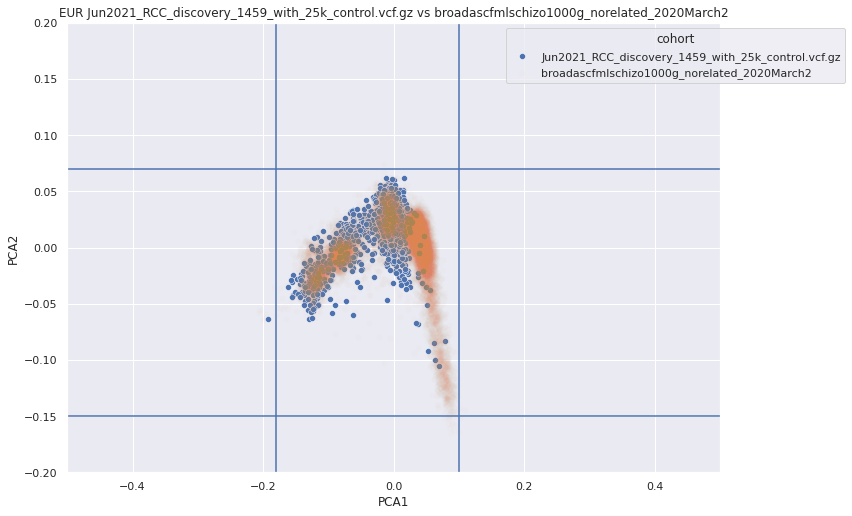

In [8]:
#Define values of PCs to exclude outliers = EUR

seaborn.set(rc={'figure.figsize':(11.7,8.27)}) # Need this before making figures

ax=seaborn.scatterplot(x="PCA1", y="PCA2", data=EUR_pca[EUR_pca.cohort==cohort_name],alpha=1.0,sizes=(20,20))

fg=seaborn.scatterplot(x="PCA1", y="PCA2", data=EUR_pca[EUR_pca.cohort=="control"],alpha=0.02,ax=ax)

fg.set(xlim=(-0.5,0.5))
fg.set(ylim=(-0.2,0.2))
fg.set_title("EUR "+cohort_name+" vs "+control_name)
fg.legend(title="cohort",labels=[cohort_name,control_name],bbox_to_anchor=(1.2,1))


EUR_PC1_min = -0.18
EUR_PC1_max = 0.1
EUR_PC2_min = -0.15
EUR_PC2_max = 0.07



plt.axvline(x= EUR_PC1_min)  #PCA1_left
plt.axvline(x=EUR_PC1_max)   #PCA1_right 
plt.axhline(y=EUR_PC2_max)   #PCA2_up 
plt.axhline(y=EUR_PC2_min)  #PCA2_down



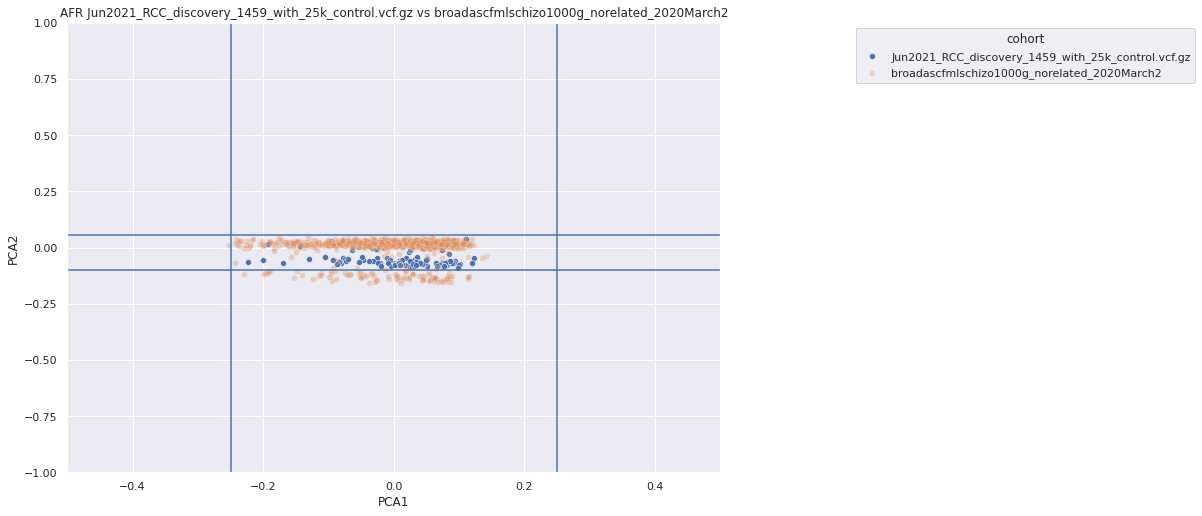

In [30]:
#Define values of PCs to exclude outliers = AFR

seaborn.set(rc={'figure.figsize':(11.7,8.27)}) # Need this before making figures

ax=seaborn.scatterplot(x="PCA1", y="PCA2", data=AFR_pca[AFR_pca.cohort==cohort_name],alpha=1.0,sizes=(20,20))

fg=seaborn.scatterplot(x="PCA1", y="PCA2", data=AFR_pca[AFR_pca.cohort=="control"],alpha=0.3, ax=ax)

fg.set(xlim=(-0.5,0.5))
fg.set(ylim=(-1,1))
fg.set_title("AFR "+cohort_name+" vs "+control_name)
fg.legend(title="cohort",labels=[cohort_name,control_name],bbox_to_anchor=(1.2,1))

AFR_PC1_min = -0.25
AFR_PC1_max = 0.25
AFR_PC2_min = -0.1
AFR_PC2_max = 0.055


plt.axvline(x= AFR_PC1_min)  #PCA1_left
plt.axvline(x=AFR_PC1_max)   #PCA1_right 
plt.axhline(y=AFR_PC2_max)   #PCA2_up 
plt.axhline(y=AFR_PC2_min)  #PCA2_down





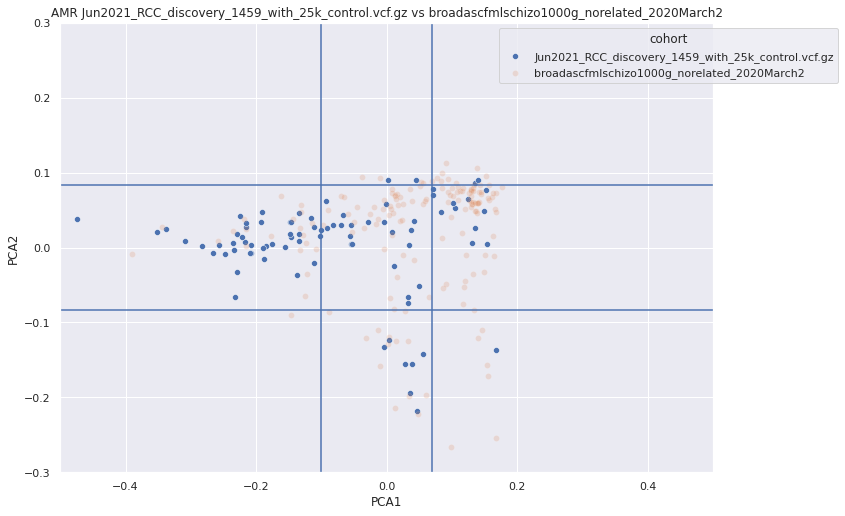

In [20]:
#Define values of PCs to exclude outliers = AMR

seaborn.set(rc={'figure.figsize':(11.7,8.27)}) # Need this before making figures

ax=seaborn.scatterplot(x="PCA1", y="PCA2", data=AMR_pca[AMR_pca.cohort==cohort_name],alpha=1.0,sizes=(20,20))

fg=seaborn.scatterplot(x="PCA1", y="PCA2", data=AMR_pca[AMR_pca.cohort=="control"],alpha=0.2, ax=ax)

fg.set(xlim=(-0.5,0.5))
fg.set(ylim=(-0.3,0.3))
fg.set_title("AMR "+cohort_name+" vs "+control_name)
fg.legend(title="cohort",labels=[cohort_name,control_name],bbox_to_anchor=(1.2,1))


AMR_PC1_min = -0.1
AMR_PC1_max = 0.07
AMR_PC2_min = -0.083
AMR_PC2_max = 0.083

plt.axvline(x= AMR_PC1_min)  #PCA1_left
plt.axvline(x=AMR_PC1_max)   #PCA1_right 
plt.axhline(y=AMR_PC2_max)   #PCA2_up 
plt.axhline(y=AMR_PC2_min)  #PCA2_down


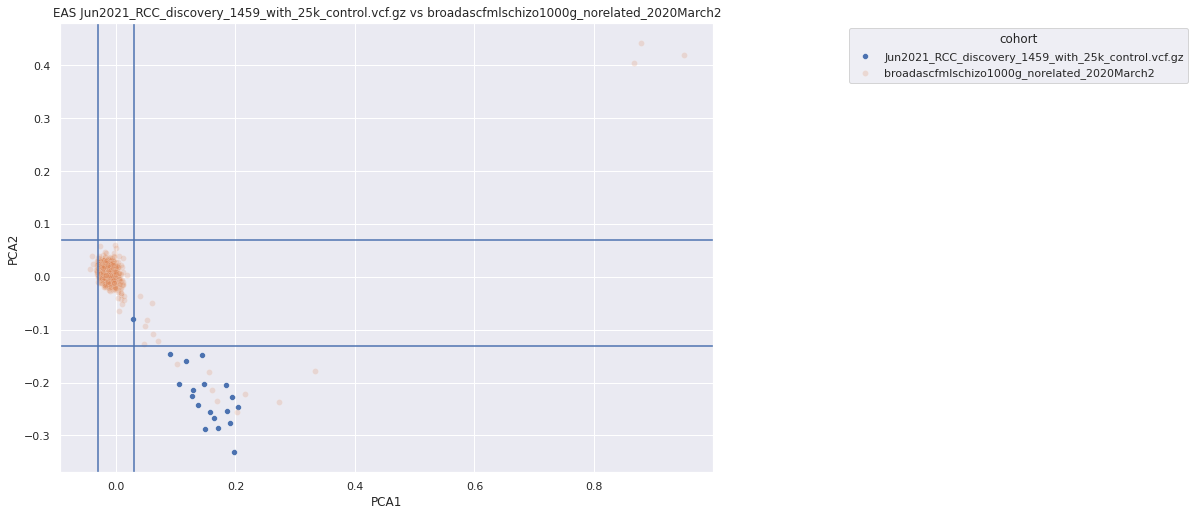

In [18]:
#Define values of PCs to exclude outliers = EAS

seaborn.set(rc={'figure.figsize':(11.7,8.27)}) # Need this before making figures

ax=seaborn.scatterplot(x="PCA1", y="PCA2", data=EAS_pca[EAS_pca.cohort==cohort_name],alpha=1.0,sizes=(20,20))

fg=seaborn.scatterplot(x="PCA1", y="PCA2", data=EAS_pca[EAS_pca.cohort=="control"],alpha=0.2, ax=ax)

#fg.set(xlim=(-0.2,0.2))
#fg.set(ylim=(-0.5,0.5))
fg.set_title("EAS "+cohort_name+" vs "+control_name)
fg.legend(title="cohort",labels=[cohort_name,control_name],bbox_to_anchor=(1.2,1))

EAS_PC1_min = -0.03
EAS_PC1_max = 0.03

EAS_PC2_min = -0.13
EAS_PC2_max = 0.07


plt.axvline(x= EAS_PC1_min)  #PCA1_left
plt.axvline(x=EAS_PC1_max)   #PCA1_right 
plt.axhline(y=EAS_PC2_max)   #PCA2_up 
plt.axhline(y=EAS_PC2_min)  #PCA2_down


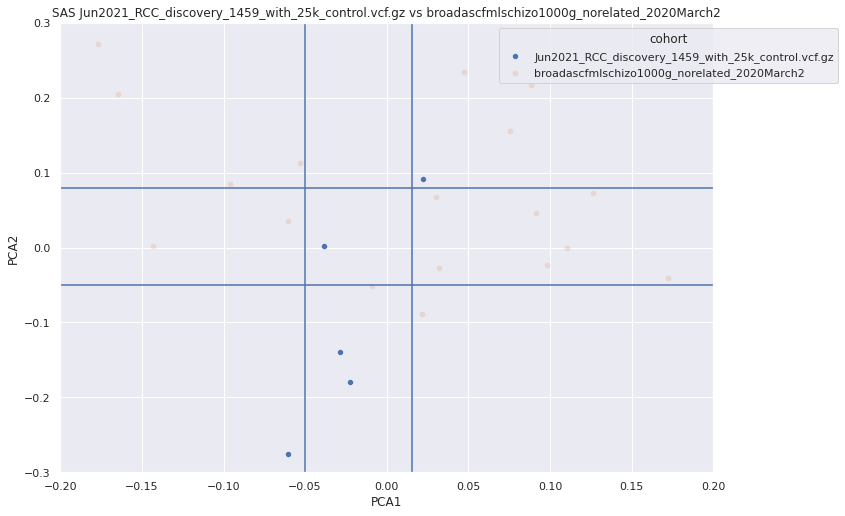

In [17]:
#Define values of PCs to exclude outliers = SAS

seaborn.set(rc={'figure.figsize':(11.7,8.27)}) # Need this before making figures

ax=seaborn.scatterplot(x="PCA1", y="PCA2", data=SAS_pca[SAS_pca.cohort==cohort_name],alpha=1.0,sizes=(20,20))

fg=seaborn.scatterplot(x="PCA1", y="PCA2", data=SAS_pca[SAS_pca.cohort=="control"],alpha=0.2, ax=ax)

fg.set(xlim=(-0.2,0.2))
fg.set(ylim=(-0.3,0.3))
fg.set_title("SAS "+cohort_name+" vs "+control_name)
fg.legend(title="cohort",labels=[cohort_name,control_name],bbox_to_anchor=(1.2,1))

SAS_PC1_min = -0.05
SAS_PC1_max = 0.0154
SAS_PC2_min = -0.05
SAS_PC2_max = 0.08

plt.axvline(x= SAS_PC1_min)  #PCA1_left
plt.axvline(x=SAS_PC1_max)   #PCA1_right 
plt.axhline(y=SAS_PC2_max)   #PCA2_up 
plt.axhline(y=SAS_PC2_min)  #PCA2_down





<b> *In case you don't have all 5 ancestry groups in your cohort, comment out lines below for absent ancestries, 
    and change the dictionary defined as "PC_coord" variable </b>

In [33]:
#Save the coordinates - for RCC cases 

EUR_coord=[EUR_PC1_min,EUR_PC1_max, EUR_PC2_min, EUR_PC2_max] 
AFR_coord=[AFR_PC1_min,AFR_PC1_max, AFR_PC2_min, AFR_PC2_max] 
#AMR_coord=[AMR_PC1_min,AMR_PC1_max, AMR_PC2_min, AMR_PC2_max] 
#EAS_coord=[EAS_PC1_min,EAS_PC1_max, EAS_PC2_min, EAS_PC2_max] 
#SAS_coord=[SAS_PC1_min,SAS_PC1_max, SAS_PC2_min, SAS_PC2_max] 
PC_coord_row=["PC1_min","PC1_max","PC2_min","PC2_max"]

PC_coord={"EUR":EUR_coord, "AFR":AFR_coord} #Change this accordingly
PC_coord_df=pd.DataFrame(PC_coord)
PC_coord_df.index=PC_coord_row


PC_coord_df.to_csv("PC_coord.txt",sep="\t")
!gsutil cp "PC_coord.txt" $bucket

Copying file://PC_coord.txt [Content-Type=text/plain]...
/ [1 files][   84.0 B/   84.0 B]                                                
Operation completed over 1 objects/84.0 B.                                       


In [23]:
#Save the coordinates 

EUR_coord=[EUR_PC1_min,EUR_PC1_max, EUR_PC2_min, EUR_PC2_max] 
AFR_coord=[AFR_PC1_min,AFR_PC1_max, AFR_PC2_min, AFR_PC2_max] 
AMR_coord=[AMR_PC1_min,AMR_PC1_max, AMR_PC2_min, AMR_PC2_max] 
EAS_coord=[EAS_PC1_min,EAS_PC1_max, EAS_PC2_min, EAS_PC2_max] 
SAS_coord=[SAS_PC1_min,SAS_PC1_max, SAS_PC2_min, SAS_PC2_max] 
PC_coord_row=["PC1_min","PC1_max","PC2_min","PC2_max"]

PC_coord={"EUR":EUR_coord, "AFR":AFR_coord, "AMR":AMR_coord, "EAS":EAS_coord, "SAS":SAS_coord} #Change this accordingly
PC_coord_df=pd.DataFrame(PC_coord)
PC_coord_df.index=PC_coord_row


PC_coord_df.to_csv("PC_coord.txt",sep="\t")
!gsutil cp "PC_coord.txt" $bucket

Copying file://PC_coord.txt [Content-Type=text/plain]...
/ [1 files][   62.0 B/   62.0 B]                                                
Operation completed over 1 objects/62.0 B.                                       


## Run pairmatch notebook and come back. 

    You should change cloud environment setting before running pairmatch notebook

For the rest of notebook including pairmatch notebook, you don't need an expensive cloud environment required for previous steps of the notebook.  
At this point, you should make a new cloud environment with Default setting that 
supports both Python and R language with moderate resource setting

## After running pairmatch notebook - Make final sample list for Variant_Level_Count

In [34]:
#Last part start here


EUR_l=bucket+'EUR_pm_exclude_list.txt'
#AMR_l=bucket+'AMR_pm_exclude_list.txt'
AFR_l=bucket+'AFR_pm_exclude_list.txt'
#SAS_l=bucket+'SAS_pm_exclude_list.txt'
#EAS_l=bucket+'EAS_pm_exclude_list.txt'

!gsutil cp $EUR_l .
#!gsutil cp $AMR_l .
!gsutil cp $AFR_l .
#!gsutil cp $SAS_l .
#!gsutil cp $EAS_l .

exclude_df_EUR=pd.read_csv("EUR_pm_exclude_list.txt", sep="\t")
#exclude_df_AMR=pd.read_csv("AMR_pm_exclude_list.txt", sep="\t")
exclude_df_AFR=pd.read_csv("AFR_pm_exclude_list.txt", sep="\t")
#exclude_df_SAS=pd.read_csv("SAS_pm_exclude_list.txt", sep="\t")
#exclude_df_EAS=pd.read_csv("EAS_pm_exclude_list.txt", sep="\t")

def exclude_samples(Original_PCA,sample_to_exclude):
    seaborn.set(rc={'figure.figsize':(11.7,8.27)}) # Need this before making figures
    exclude_list=sample_to_exclude.final_ex_list.tolist()
    final_df=Original_PCA[Original_PCA['sample_original'].apply(lambda x : x not in exclude_list)]
    return final_df

EUR_final=exclude_samples(EUR_pca,exclude_df_EUR)
AFR_final=exclude_samples(AFR_pca,exclude_df_AFR)
#AMR_final=exclude_samples(AMR_pca,exclude_df_AMR)
#EAS_final=exclude_samples(EAS_pca,exclude_df_EAS)
#SAS_final=exclude_samples(SAS_pca,exclude_df_SAS)

def make_final_output(input_df,population):
    control_output_list=input_df.sample_original[input_df.cohort=="control"]
    control_output_list=pd.DataFrame(control_output_list)
    control_output_list=control_output_list.rename(columns={'sample_original':"original_sample"})
    control_output_list=control_output_list.rename(columns={'Inferred_ancestry':"inferred_ancestry_umap"})
    control_output_list["inferred_ancestry_umap"]=population
    
    case_output_list=input_df.sample_original[input_df.cohort==cohort_name]
    case_output_list=pd.DataFrame(case_output_list)
    case_output_list=case_output_list.rename(columns={'sample_original':"original_sample"})
    case_output_list=case_output_list.rename(columns={'Inferred_ancestry':"inferred_ancestry_umap"})
    case_output_list["inferred_ancestry_umap"]=population
    
    return control_output_list, case_output_list


EUR_control_list, EUR_case_list = make_final_output(EUR_final,"EUR")
AFR_control_list, AFR_case_list = make_final_output(AFR_final,"AFR")
#AMR_control_list, AMR_case_list = make_final_output(AMR_final,"AMR")
#EAS_control_list, EAS_case_list = make_final_output(EAS_final,"EAS")
#SAS_control_list, SAS_case_list = make_final_output(SAS_final,"SAS")

EUR_control_list.to_csv("EUR_final_control_list.txt",sep="\t")
AFR_control_list.to_csv("AFR_final_control_list.txt",sep="\t")
#AMR_control_list.to_csv("AMR_final_control_list.txt",sep="\t")
#EAS_control_list.to_csv("EAS_final_control_list.txt",sep="\t")
#SAS_control_list.to_csv("SAS_final_control_list.txt",sep="\t")

EUR_case_list.to_csv("EUR_final_case_list.txt",sep="\t")
AFR_case_list.to_csv("AFR_final_case_list.txt",sep="\t")
#AMR_case_list.to_csv("AMR_final_case_list.txt",sep="\t")
#EAS_case_list.to_csv("EAS_final_case_list.txt",sep="\t")
#SAS_case_list.to_csv("SAS_final_case_list.txt",sep="\t")


!gsutil cp "*list.txt" $bucket

Copying gs://fc-2cae157b-a485-483f-8f33-054640ba106f/98c214bc-6197-41ea-9885-0813c7d22138/Ancestry_Inference/3ea7ff94-130e-43e6-9a36-f8fbd6c800f9/call-CombineVariants/EUR_pm_exclude_list.txt...
/ [1 files][ 85.3 KiB/ 85.3 KiB]                                                
Operation completed over 1 objects/85.3 KiB.                                     
Copying gs://fc-2cae157b-a485-483f-8f33-054640ba106f/98c214bc-6197-41ea-9885-0813c7d22138/Ancestry_Inference/3ea7ff94-130e-43e6-9a36-f8fbd6c800f9/call-CombineVariants/AFR_pm_exclude_list.txt...
/ [1 files][  668.0 B/  668.0 B]                                                
Operation completed over 1 objects/668.0 B.                                      
Copying file://SAS_final_case_list.txt [Content-Type=text/plain]...
Copying file://EAS_pm_exclude_list.txt [Content-Type=text/plain]...             
Copying file://SAS_pm_exclude_list.txt [Content-Type=text/plain]...             
Copying file://AFR_pm_exclude_list.txt [Content-Type=tex

In [5]:
#Last part start here


EUR_l=bucket+'EUR_pm_exclude_list.txt'
AMR_l=bucket+'AMR_pm_exclude_list.txt'
AFR_l=bucket+'AFR_pm_exclude_list.txt'
SAS_l=bucket+'SAS_pm_exclude_list.txt'
EAS_l=bucket+'EAS_pm_exclude_list.txt'

!gsutil cp $EUR_l .
!gsutil cp $AMR_l .
!gsutil cp $AFR_l .
!gsutil cp $SAS_l .
!gsutil cp $EAS_l .

exclude_df_EUR=pd.read_csv("EUR_pm_exclude_list.txt", sep="\t")
exclude_df_AMR=pd.read_csv("AMR_pm_exclude_list.txt", sep="\t")
exclude_df_AFR=pd.read_csv("AFR_pm_exclude_list.txt", sep="\t")
exclude_df_SAS=pd.read_csv("SAS_pm_exclude_list.txt", sep="\t")
exclude_df_EAS=pd.read_csv("EAS_pm_exclude_list.txt", sep="\t")

def exclude_samples(Original_PCA,sample_to_exclude):
    seaborn.set(rc={'figure.figsize':(11.7,8.27)}) # Need this before making figures
    exclude_list=sample_to_exclude.final_ex_list.tolist()
    final_df=Original_PCA[Original_PCA['sample_original'].apply(lambda x : x not in exclude_list)]
    return final_df

EUR_final=exclude_samples(EUR_pca,exclude_df_EUR)
AFR_final=exclude_samples(AFR_pca,exclude_df_AFR)
AMR_final=exclude_samples(AMR_pca,exclude_df_AMR)
EAS_final=exclude_samples(EAS_pca,exclude_df_EAS)
SAS_final=exclude_samples(SAS_pca,exclude_df_SAS)

def make_final_output(input_df,population):
    control_output_list=input_df.sample_original[input_df.cohort=="control"]
    control_output_list=pd.DataFrame(control_output_list)
    control_output_list=control_output_list.rename(columns={'sample_original':"original_sample"})
    control_output_list=control_output_list.rename(columns={'Inferred_ancestry':"inferred_ancestry_umap"})
    control_output_list["inferred_ancestry_umap"]=population
    
    case_output_list=input_df.sample_original[input_df.cohort==cohort_name]
    case_output_list=pd.DataFrame(case_output_list)
    case_output_list=case_output_list.rename(columns={'sample_original':"original_sample"})
    case_output_list=case_output_list.rename(columns={'Inferred_ancestry':"inferred_ancestry_umap"})
    case_output_list["inferred_ancestry_umap"]=population
    
    return control_output_list, case_output_list


EUR_control_list, EUR_case_list = make_final_output(EUR_final,"EUR")
AFR_control_list, AFR_case_list = make_final_output(AFR_final,"AFR")
AMR_control_list, AMR_case_list = make_final_output(AMR_final,"AMR")
EAS_control_list, EAS_case_list = make_final_output(EAS_final,"EAS")
SAS_control_list, SAS_case_list = make_final_output(SAS_final,"SAS")

EUR_control_list.to_csv("EUR_final_control_list.txt",sep="\t")
AFR_control_list.to_csv("AFR_final_control_list.txt",sep="\t")
AMR_control_list.to_csv("AMR_final_control_list.txt",sep="\t")
EAS_control_list.to_csv("EAS_final_control_list.txt",sep="\t")
SAS_control_list.to_csv("SAS_final_control_list.txt",sep="\t")

EUR_case_list.to_csv("EUR_final_case_list.txt",sep="\t")
AFR_case_list.to_csv("AFR_final_case_list.txt",sep="\t")
AMR_case_list.to_csv("AMR_final_case_list.txt",sep="\t")
EAS_case_list.to_csv("EAS_final_case_list.txt",sep="\t")
SAS_case_list.to_csv("SAS_final_case_list.txt",sep="\t")


!gsutil cp "*list.txt" $bucket

Copying gs://fc-2cae157b-a485-483f-8f33-054640ba106f/98c214bc-6197-41ea-9885-0813c7d22138/Ancestry_Inference/3ea7ff94-130e-43e6-9a36-f8fbd6c800f9/call-CombineVariants/EUR_pm_exclude_list.txt...
/ [1 files][  2.2 KiB/  2.2 KiB]                                                
Operation completed over 1 objects/2.2 KiB.                                      
Copying gs://fc-2cae157b-a485-483f-8f33-054640ba106f/98c214bc-6197-41ea-9885-0813c7d22138/Ancestry_Inference/3ea7ff94-130e-43e6-9a36-f8fbd6c800f9/call-CombineVariants/AMR_pm_exclude_list.txt...
/ [1 files][  880.0 B/  880.0 B]                                                
Operation completed over 1 objects/880.0 B.                                      
Copying gs://fc-2cae157b-a485-483f-8f33-054640ba106f/98c214bc-6197-41ea-9885-0813c7d22138/Ancestry_Inference/3ea7ff94-130e-43e6-9a36-f8fbd6c800f9/call-CombineVariants/AFR_pm_exclude_list.txt...
/ [1 files][  762.0 B/  762.0 B]                                                
Operation c

In [3]:
bucket ='gs://fc-2cae157b-a485-483f-8f33-054640ba106f/98c214bc-6197-41ea-9885-0813c7d22138/Ancestry_Inference/3ea7ff94-130e-43e6-9a36-f8fbd6c800f9/call-CombineVariants/'

In [10]:
er=bucket+'*list.txt'

In [15]:
EUR_case_list=pd.read_table("EUR_final_case_list.txt",sep="\t")
EUR_control_list=pd.read_table("EUR_final_control_list.txt",sep="\t")

AFR_case_list=pd.read_table("AFR_final_case_list.txt",sep="\t")
AFR_control_list=pd.read_table("AFR_final_control_list.txt",sep="\t")

In [16]:
len(EUR_case_list),len(EUR_control_list),len(AFR_case_list),len(AFR_control_list)

(1209, 8463, 134, 938)

In [18]:
case_final=pd.concat([EUR_case_list,AFR_case_list])
control_final=pd.concat([EUR_control_list,AFR_control_list])

In [21]:
case_final.to_csv("Discovery_case_final_list_ratio.txt",sep="\t",index=False)
control_final.to_csv("Discovery_control_final_list_ratio.txt",sep="\t",index=False)

!gsutil cp "*list_ratio.txt" $bucket

Copying file://Discovery_control_final_list_ratio.txt [Content-Type=text/plain]...
Copying file://Discovery_case_final_list_ratio.txt [Content-Type=text/plain]... 
/ [2 files][202.3 KiB/202.3 KiB]                                                
Operation completed over 2 objects/202.3 KiB.                                    


In [12]:
EUR_l=bucket+'*list.txt'
!gsutil cp $er .

Copying gs://fc-2cae157b-a485-483f-8f33-054640ba106f/98c214bc-6197-41ea-9885-0813c7d22138/Ancestry_Inference/3ea7ff94-130e-43e6-9a36-f8fbd6c800f9/call-CombineVariants/AFR_final_case_list.txt...
Copying gs://fc-2cae157b-a485-483f-8f33-054640ba106f/98c214bc-6197-41ea-9885-0813c7d22138/Ancestry_Inference/3ea7ff94-130e-43e6-9a36-f8fbd6c800f9/call-CombineVariants/AFR_final_control_list.txt...
Copying gs://fc-2cae157b-a485-483f-8f33-054640ba106f/98c214bc-6197-41ea-9885-0813c7d22138/Ancestry_Inference/3ea7ff94-130e-43e6-9a36-f8fbd6c800f9/call-CombineVariants/AFR_pm_exclude_list.txt...
Copying gs://fc-2cae157b-a485-483f-8f33-054640ba106f/98c214bc-6197-41ea-9885-0813c7d22138/Ancestry_Inference/3ea7ff94-130e-43e6-9a36-f8fbd6c800f9/call-CombineVariants/AMR_final_case_list.txt...
/ [4 files][ 22.6 KiB/ 22.6 KiB]                                                
==> NOTE: You are performing a sequence of gsutil operations that may
run significantly faster if you instead use gsutil -m cp ... Please
se

In [36]:
##Check final samplee count for controls 
len(EUR_control_list),len(AFR_control_list)#,len(AMR_control_list),len(EAS_control_list),len(SAS_control_list)

(8463, 938)

In [37]:
##Check final samplee count for cases
len(EUR_case_list),len(AFR_case_list)#,len(AMR_case_list),len(EAS_case_list),len(SAS_case_list)

(1209, 134)

## (Optional) Plot PCs after outlier exclusion

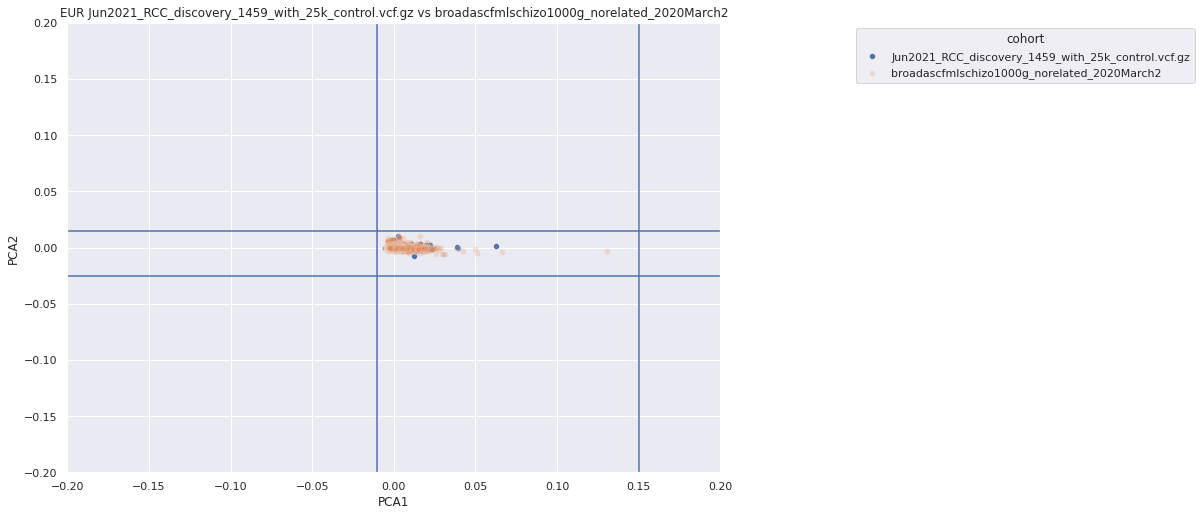

In [14]:
#Plot EUR after exclusion


seaborn.set(rc={'figure.figsize':(11.7,8.27)}) 

ax=seaborn.scatterplot(x="PCA1", y="PCA2", data=EUR_final[EUR_final.cohort==cohort_name],alpha=1.0,sizes=(20,20))
fg=seaborn.scatterplot(x="PCA1", y="PCA2", data=EUR_final[EUR_final.cohort=="control"],alpha=0.2, ax=ax)

fg.set(xlim=(-0.2,0.2))
fg.set(ylim=(-0.2,0.2))
fg.set_title("EUR "+cohort_name+" vs "+control_name)
fg.legend(title="cohort",labels=[cohort_name,control_name],bbox_to_anchor=(1.2,1))



plt.axvline(x= EUR_PC1_min)  #PCA1_left
plt.axvline(x=EUR_PC1_max)   #PCA1_right 
plt.axhline(y=EUR_PC2_max)   #PCA2_up 
plt.axhline(y=EUR_PC2_min)  #PCA2_down


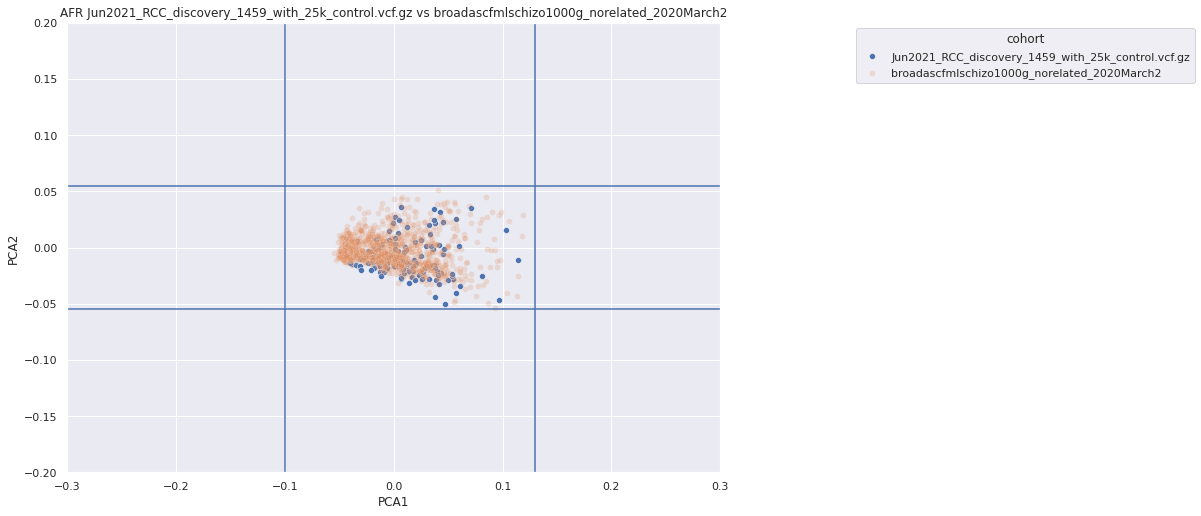

In [16]:
#Plot AFR after exclusion

seaborn.set(rc={'figure.figsize':(11.7,8.27)}) # Need this before making figures

ax=seaborn.scatterplot(x="PCA1", y="PCA2", data=AFR_final[AFR_final.cohort==cohort_name],alpha=1.0,sizes=(20,20))

fg=seaborn.scatterplot(x="PCA1", y="PCA2", data=AFR_final[AFR_final.cohort=="control"],alpha=0.2, ax=ax)

fg.set(xlim=(-0.3,0.3))
fg.set(ylim=(-0.2,0.2))
fg.set_title("AFR "+cohort_name+" vs "+control_name)
fg.legend(title="cohort",labels=[cohort_name,control_name],bbox_to_anchor=(1.2,1))

plt.axvline(x= AFR_PC1_min)  #PCA1_left
plt.axvline(x=AFR_PC1_max)   #PCA1_right 
plt.axhline(y=AFR_PC2_max)   #PCA2_up 
plt.axhline(y=AFR_PC2_min)  #PCA2_down


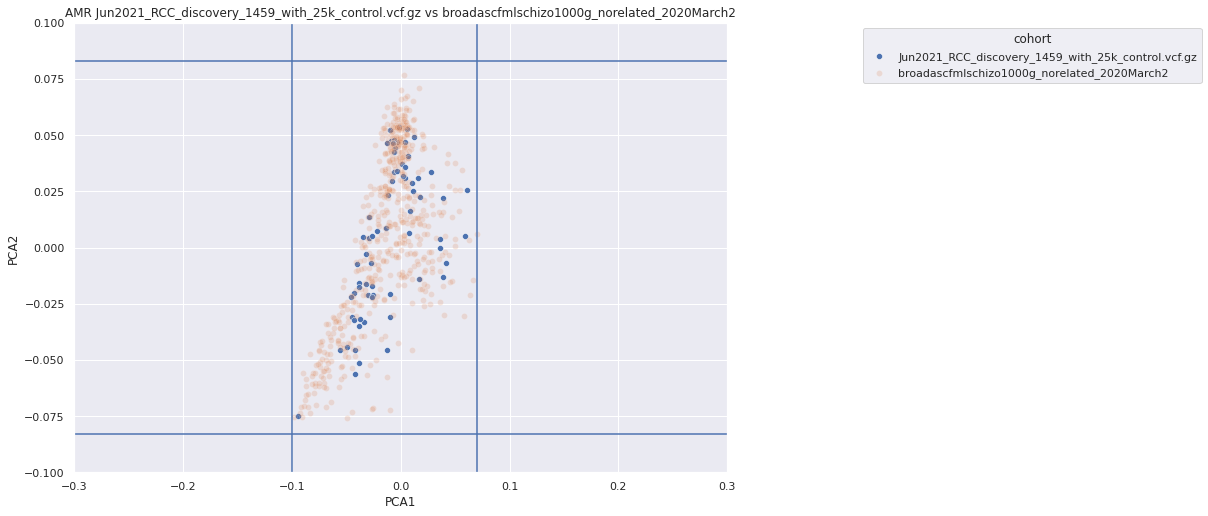

In [17]:
#Plot AMR after exclusion

seaborn.set(rc={'figure.figsize':(11.7,8.27)}) # Need this before making figures

ax=seaborn.scatterplot(x="PCA1", y="PCA2", data=AMR_final[AMR_final.cohort==cohort_name],alpha=1.0,sizes=(20,20))

fg=seaborn.scatterplot(x="PCA1", y="PCA2", data=AMR_final[AMR_final.cohort=="control"],alpha=0.2, ax=ax)

fg.set(xlim=(-0.3,0.3))
fg.set(ylim=(-0.1,0.1))
fg.set_title("AMR "+cohort_name+" vs "+control_name)
fg.legend(title="cohort",labels=[cohort_name,control_name],bbox_to_anchor=(1.2,1))

plt.axvline(x= AMR_PC1_min)  #PCA1_left
plt.axvline(x=AMR_PC1_max)   #PCA1_right 
plt.axhline(y=AMR_PC2_max)   #PCA2_up 
plt.axhline(y=AMR_PC2_min)  #PCA2_down

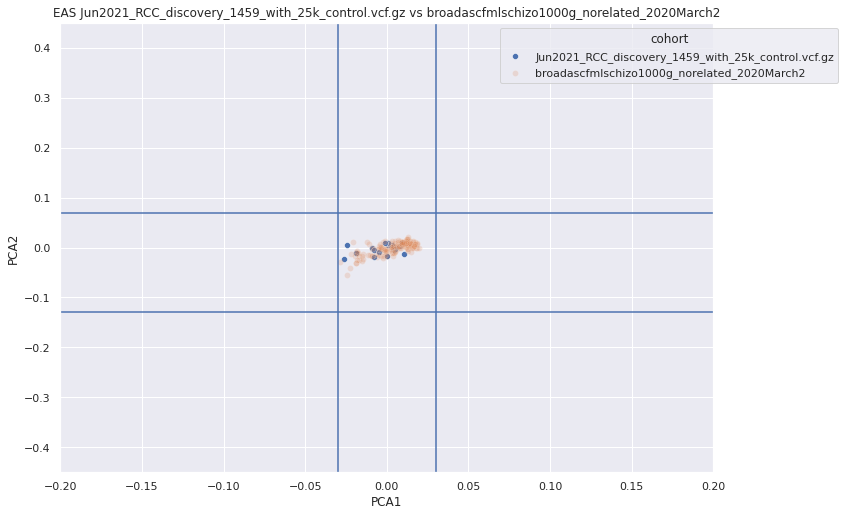

In [18]:
#Plot EAS after exclusion

seaborn.set(rc={'figure.figsize':(11.7,8.27)}) # Need this before making figures

ax=seaborn.scatterplot(x="PCA1", y="PCA2", data=EAS_final[EAS_final.cohort==cohort_name],alpha=1.0,sizes=(20,20))

fg=seaborn.scatterplot(x="PCA1", y="PCA2", data=EAS_final[EAS_final.cohort=="control"],alpha=0.2, ax=ax)

fg.set(xlim=(-0.2,0.2))
fg.set(ylim=(-0.45,0.45))
fg.set_title("EAS "+cohort_name+" vs "+control_name)
fg.legend(title="cohort",labels=[cohort_name,control_name],bbox_to_anchor=(1.2,1))
plt.axvline(x= EAS_PC1_min)  #PCA1_left
plt.axvline(x=EAS_PC1_max)   #PCA1_right 
plt.axhline(y=EAS_PC2_max)   #PCA2_up 
plt.axhline(y=EAS_PC2_min)  #PCA2_down



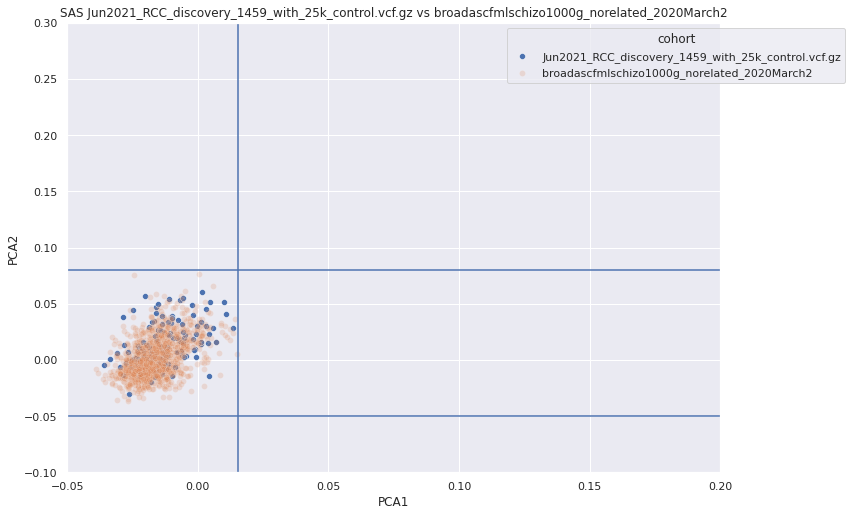

In [19]:
#Plot SAS after exclusion

seaborn.set(rc={'figure.figsize':(11.7,8.27)}) # Need this before making figures

ax=seaborn.scatterplot(x="PCA1", y="PCA2", data=SAS_final[SAS_final.cohort==cohort_name],alpha=1.0,sizes=(20,20))

fg=seaborn.scatterplot(x="PCA1", y="PCA2", data=SAS_final[SAS_final.cohort=="control"],alpha=0.2, ax=ax)

fg.set(xlim=(-0.05,0.2))
fg.set(ylim=(-0.1,0.3))
fg.set_title("SAS "+cohort_name+" vs "+control_name)
fg.legend(title="cohort",labels=[cohort_name,control_name],bbox_to_anchor=(1.2,1))

plt.axvline(x= SAS_PC1_min)  #PCA1_left
plt.axvline(x=SAS_PC1_max)   #PCA1_right 
plt.axhline(y=SAS_PC2_max)   #PCA2_up 
plt.axhline(y=SAS_PC2_min)  #PCA2_down
